In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/My Drive/hotel_service/data/train_0109_3.csv'
train = pd.read_csv(file_path, low_memory=False)

train.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_since,...,zipcode,y,num_top_amenities,host_experience_years,cancellation_policy_encoded,review_scores_rating_bucket,city_neighbourhood_avg_price,zipcode3,zipcode3_avg_price,bedrooms_accommodates_avg_price
0,6,2.0,Real Bed,1.0,4.0,LA,t,t,f,2016-07-13,...,90804,138.0,4,9.4658,0,0,122.221328,908,122.335354,167.840256
1,2,1.0,Real Bed,1.0,1.0,DC,t,t,t,2015-12-30,...,20018,42.0,10,10.0027,2,2,144.558140,200,217.374443,107.559683
2,2,2.0,Real Bed,1.0,1.0,NYC,t,t,f,2016-05-21,...,11221,65.0,9,9.6110,2,2,81.804928,112,117.185048,107.590912
3,2,1.0,Real Bed,1.0,1.0,SF,t,t,t,2012-06-19,...,94133,166.0,9,13.5315,2,2,210.928571,941,227.731430,107.440295
4,2,1.0,Real Bed,1.0,1.0,NYC,t,t,t,2015-03-25,...,10024,165.0,10,10.7699,2,2,184.027348,100,180.109475,107.084773


In [3]:
pip install shap



Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5050
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 25
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 108.809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

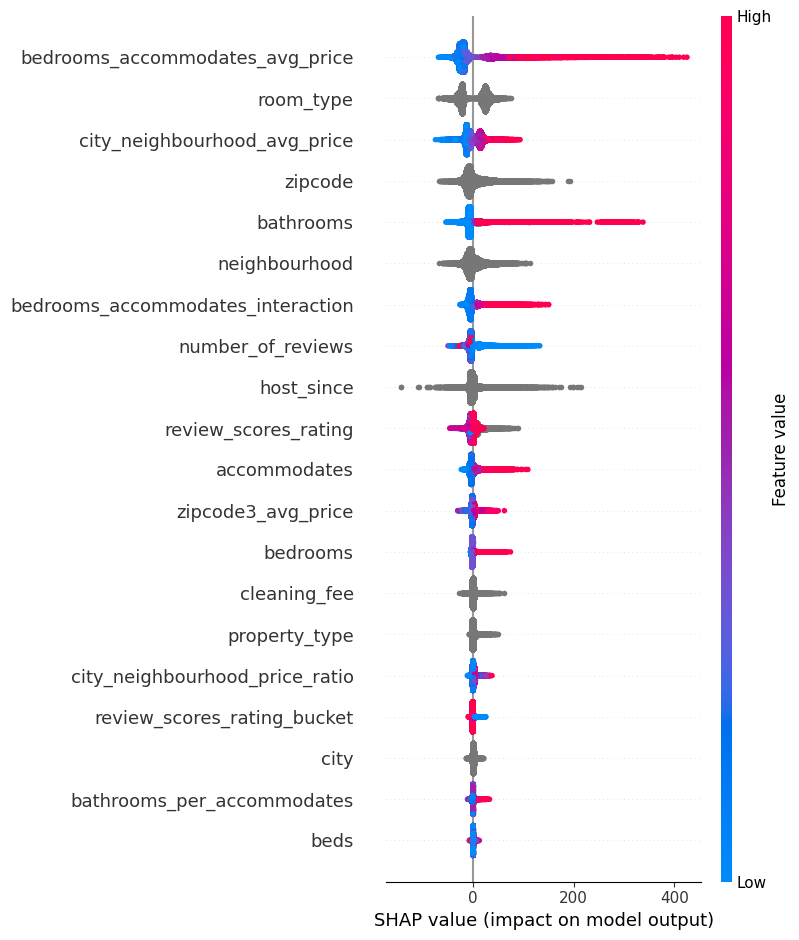

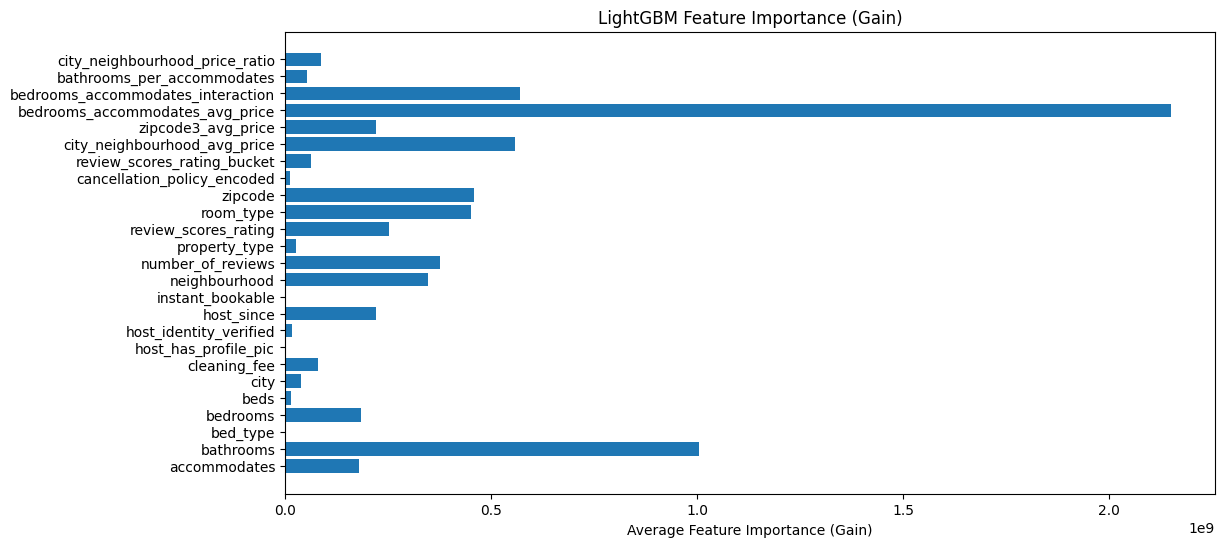

In [7]:
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# データの読み込み
file_path = '/content/drive/My Drive/hotel_service/data/train_0109_3.csv'
train = pd.read_csv(file_path, low_memory=False)

train['bedrooms_accommodates_interaction'] = train['bedrooms'] * train['accommodates']
train['bathrooms_per_accommodates'] = train['bathrooms'] / (train['accommodates'] + 1) # 0除算防止
train['city_neighbourhood_price_ratio'] = train['city_neighbourhood_avg_price'] / (train['bedrooms'] + 1)

# 特徴量と目的変数の分割
X = train.drop(columns=['y', 'zipcode3', 'longitude', 'latitude', 'num_top_amenities', 'host_experience_years']).copy()
y = train['y'].copy()

# object型のカラムをcategory型に変換
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# カテゴリ変数のリスト作成
categorical_features = list(X.select_dtypes(include='category').columns)

# KFoldの設定（5分割）
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# SHAP値の保存用リスト
shap_values_all = []
feature_importances = np.zeros(X.shape[1])
rmse_scores = []
val_indices = []  # ★ 追加：バリデーションデータのインデックスを保存

# クロスバリデーションでモデルを訓練
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    val_indices.append(val_idx)  # ★ 保存

    # LightGBMデータセットの作成
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

    # モデルのハイパーパラメータ設定
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 50,
        'max_depth': 8,
        'min_data_in_leaf': 50,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 1.0,
        'lambda_l2': 1.0,
        'seed': 42
    }

    # ★ コールバック関数の適用
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=50)
    ]

    # モデルのトレーニング（コールバックを適用）
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_val],
        callbacks=callbacks
    )

    # SHAPの解釈器作成とSHAP値計算
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap_values_all.append(shap_values)

    # 特徴量重要度の加算
    feature_importances += model.feature_importance(importance_type="gain")

    # RMSE計算
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    print(f"RMSE for Fold {fold + 1}: {rmse:.4f}")

# 平均RMSEの表示
mean_rmse = np.mean(rmse_scores)
print(f"\nAverage RMSE across all folds: {mean_rmse:.4f}")

# --- SHAP値の可視化（全データ統合してプロット） ---
# ★ 修正: すべてのSHAP値を統合する
shap_values_combined = np.vstack(shap_values_all)
X_val_combined = pd.concat([X.iloc[val_idx] for val_idx in val_indices])

# 特徴量の寄与度の可視化（SHAP Summary Plot）
shap.summary_plot(shap_values_combined, X_val_combined)

# LightGBMの特徴量重要度の可視化（Gainベース）
plt.figure(figsize=(12, 6))
plt.barh(X.columns, feature_importances / kf.n_splits)
plt.xlabel("Average Feature Importance (Gain)")
plt.title("LightGBM Feature Importance (Gain)")
plt.show()
